Proyecto Telecom X - Etapa 2 - Machine Learning
---

# Predicción de Evasión (Churn) de clientes.

## Índice

# 1. Descripción del proyecto

En este proyecto se desarrollarán modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación explorado en la etapa anterior, por lo que en el presente notebook se construirá un pipeline robusto para esta etapa inicial de modelado, en el cual se llevarán a cabo las siguientes tareas:


* Preparar los datos para el modelado (tratamiento, codificación, normalización).
* Realizar análisis de correlación y selección de variables.
* Entrenar diferentes modelos de clasificación, evaluar el rendimiento de estos a través de distintas métricas e interpretar los resultados de cada uno de ellos.
* Finalmente, se creará un reporte con una conclusión estratégica señalando los principales factores que influyen en la cancelación.

# 2. Importación de librerías y configuraciones

## Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import pickle

from pathlib import Path

import imblearn
from imblearn.under_sampling import NearMiss

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Paths

In [2]:
PROJECT_PATH = 'C:/Users/Ignacio/JupyterScripts/ONE/challenge_telecomX_parte_2'

src = Path('src')
DATA_PATH = PROJECT_PATH / src

img = Path('img')
IMG_PATH = PROJECT_PATH / img

models = Path('models')
MODELS_PATH = PROJECT_PATH / models

reports = Path('reports')
REPORTS_PATH = PROJECT_PATH / reports


dirs = [DATA_PATH, IMG_PATH, MODELS_PATH, REPORTS_PATH]


for directory in dirs:
    if not directory.exists():
        directory.mkdir(parents=True)
        print(f'Directoryo creado:\n{directory}\n')
    else:
        print(f'El directorio ya existe:\n{directory}\n')

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\src

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\img

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\models

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\reports



## Funciones

In [3]:
# Estandarización de colores
sns.set_palette('colorblind')
churn_colors = ['#4682b4', '#e9611d']

In [4]:
def metricas_generales(modelo, 
                       x_val: pd.core.frame.DataFrame,
                       y_val: pd.core.series.Series, 
                       nombre: str):
    """
    Funcion que calcula métricas de modelos clasificación
    ------------------------------------------------------------
    Parámetros:
        modelo:
            Modelo de Machine Learning Scikit-learn (debe contar con el método predict)
        x_val: pandas.core.frame.DataFrame
            DataFrame con las variables explicativas utilizadas para validar el modelo
        y_val: pandas.core.series.Series
            Pandas Series con las etiquetas reales de los datos utilizados para validar el modelo
        nombre: str
            Nombre que identificará el modelo para comparaciones
    ------------------------------------------------------------
    Returns:
        Diccionario con nombre del modelo y metricas: Accuracy, Precision, Recall, F1-score
    """
    
    metricas = {}
    y_pred = modelo.predict(x_val)
    metricas['Model'] = nombre
    metricas['Accuracy'] = np.round(accuracy_score(y_val, y_pred), 4)
    metricas['Precision'] = np.round(precision_score(y_val, y_pred), 4)
    metricas['Recall'] = np.round(recall_score(y_val, y_pred), 4)
    metricas['F1-score'] = np.round(f1_score(y_val, y_pred), 4)

    return metricas

In [5]:
def boxplot_churn(df: pd.DataFrame,
                  ycol: str,
                  ylabel: str=None,
                  title_translate: str=None):
    
    """    
    Genera y guarda un boxplot que muestra la distribución de una variable numérica 
    (`ycol`) según la condición de churn de los clientes.
    --------------------------------------------------------------------------------------------------
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame que contiene los datos a graficar. Debe incluir las columnas 'Churn' y `ycol`.
    ycol : str
        Nombre de la columna numérica cuya distribución se desea visualizar.
    ylabel : str, opcional
        Etiqueta personalizada para el eje Y. Si no se especifica, se usa `ycol`.
    title_translate : str, opcional
        Nombre personalizado para mostrar en el título del gráfico. Si no se especifica, se usa `ycol`.
    --------------------------------------------------------------------------------------------------
    Guardado
    --------
    Guarda el gráfico como imagen PNG en la ruta `figures_path` con el nombre `boxplot_Churn_<ycol>.png`.
    --------------------------------------------------------------------------------------------------
    Retorna
    -------
    fig: matplotlib.figure.Figure
        Objeto de figura de Matplotlib con los gráficos generados.
    
    """

    if ylabel is None:
        ylabel = ycol
    if title_translate is None:
        title_translate = ycol
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax = sns.boxplot(data=df, x='Churn', y=ycol, hue='Churn', palette=churn_colors)
    plt.title(f'Distribución de {title_translate} según\nEvasión (Churn) de clientes', fontsize=18, pad=20)
    plt.xlabel('Churn', fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.xticks(fontsize=13)
    plt.grid(True)
    
    fig.savefig(IMG_PATH/f'boxplot_Churn_{ycol}.png',
                transparent=False,
                dpi=300,
                bbox_inches='tight')
    plt.show()
    return fig

# 3. Preprocesamiento de datos

Para el análisis, incluiré los registros que fueron clasificados como **outliers** en la etapa anterior en la cual se desarrolló la exploración y análisis de la base de datos, ya que en este caso representan comportamientos reales e importantes, como el de clientes con gasto acumulado muy alto que igual abandonan la empresa.

In [6]:
URL = 'https://raw.githubusercontent.com/ignaciomajo/proyecto_TelecomX/refs/heads/main/src/preprocessed_TelecomX_data.json'

datos = pd.read_json(URL)
datos.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesDaily,ChargesMonthly,ChargesTotal,Churn
0,0002-ORFBO,Female,No,Yes,Yes,9,Yes,No,DSL,No,...,Yes,Yes,No,One year,Yes,Mailed check,2.19,65.6,593.30,No
1,0003-MKNFE,Male,No,No,No,9,Yes,Yes,DSL,No,...,No,No,Yes,Month-to-month,No,Mailed check,2.00,59.9,542.40,No
2,0004-TLHLJ,Male,No,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,2.46,73.9,280.85,Yes
3,0011-IGKFF,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.27,98.0,1237.85,Yes
4,0013-EXCHZ,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.80,83.9,267.40,Yes


***Nota**: inicialmente, se eliminarán las varialbes `CustomerID` ya que esta no aporta poder predictivo debido a que es un simple identificador de cliente, y `ChargesDaily` ya que esta variable fue agregada simplemente al dividir `ChargesMonthly` en 30 días, lo cual resulta redundante y no aporta ningun valor agregado al análisis.*

In [7]:
try:
    URL = 'https://raw.githubusercontent.com/ignaciomajo/proyecto_TelecomX/refs/heads/main/src/clientes_altovalor_abandonan.json'
    outliers = pd.read_json(URL)
    # Concatenar ambos DafaFrame verticalmente
    datos = pd.concat([datos, outliers], axis=0)
    # Mezclar los datos ya que sino quedaran los outliers ubicados todos al final
    datos = datos.sample(frac=1, random_state=42).reset_index(drop=True)
except Exception as e:
    print('No se encontró el archivo correspondiente, o hubo un problema al cargar los datos')
    print(f'Error: {e}')

In [8]:
datos = datos.drop(['CustomerID', 'ChargesDaily'], axis=1)

## Encoding de variables categóricas

In [9]:
datos.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesMonthly', 'ChargesTotal', 'Churn'],
      dtype='object')

In [10]:
X = datos.drop('Churn', axis=1)
y = datos['Churn']

In [11]:
categoricas = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [12]:
one_hot = make_column_transformer(
                    (OneHotEncoder(drop='if_binary'), categoricas),
                    remainder='passthrough',
                    sparse_threshold=0,
                    force_int_remainder_cols=False
)

label_encoder = LabelEncoder()

In [13]:
X = one_hot.fit_transform(X)

y = label_encoder.fit_transform(y)

In [14]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
# Mantendré una copia de los array Numpy para al final del proyecto crear Redes Neuronales con PyTorch
X_torch = X.copy()

y_torch = y.copy()

In [16]:
columnas = one_hot.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [17]:
df = pd.DataFrame(X, columns=columnas_encoded)
df

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,19.80,19.80
1,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,67.0,60.05,3994.05
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,60.0,99.80,5985.75
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,35.10,101.10
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,63.0,79.85,4861.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7147,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,46.0,19.95,907.05
7148,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19.15,19.15
7149,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,23.90,97.50
7150,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19.55,19.55


In [18]:
df_y = pd.DataFrame(y, columns=['Churn'])

In [19]:
df = pd.concat([df, df_y], axis=1)
df.head()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,19.80,19.80,0
1,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.0,60.05,3994.05,0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,60.0,99.80,5985.75,0
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,35.10,101.10,0
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,63.0,79.85,4861.45,0


### **Nota:**
Se puede observar que la única columna en la cual `1 = No` es `InternetService`. Esto puede resultar confuso debido a quel el resto de variables tienen formato `1 = Yes`, por lo que, para mantener la consistencia semántica del análisis, transformaré el nombre de esta columna de:

`InternetService_No` -> `NoInternetService`


Otro posible acercamiento sería mantener solo las columnas `InternetService_DSL` e `InternetService_Fiberoptic`, ya que la ausencia de ambas, es decir, ambas con **valor = 0** indicaría la presencia de `InternetService_No`. Pero inicialmente mantendré todas las columnas hasta generar y evaluar el modelo base.

In [20]:
df.rename(columns={'InternetService_No': 'NoInternetService'}, inplace=True)
df.sample(10)

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
1042,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,12.0,95.70,1184.00,0
5633,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,52.0,81.40,4354.45,0
6615,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,39.0,45.05,1790.60,0
6487,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19.65,19.65,1
89,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,7.0,69.95,529.50,1
890,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,4.0,20.50,77.60,0
793,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,9.0,94.40,857.25,1
3714,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,79.20,79.20,1
406,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,4.0,80.15,319.85,0
2114,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,4.0,50.95,207.35,0


## Balance del Dataset

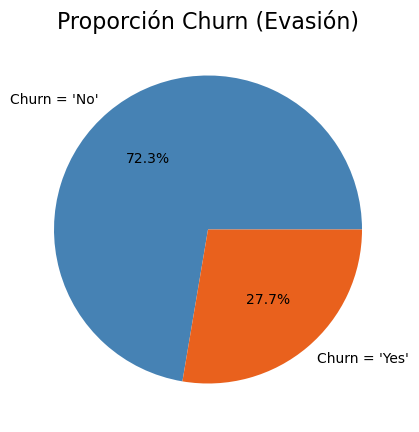

In [21]:
# Visualizar la proporción de registros en relación a la evasión (Churn)
churns = df.groupby('Churn')['Churn'].value_counts()
churns = pd.DataFrame(churns)
fig, ax = plt.subplots(figsize=(6,5))
ax = plt.pie(data=churns,
             x=churns['count'],
             labels=["Churn = 'No'", "Churn = 'Yes'"],
             autopct='%1.1f%%',
             colors=churn_colors)

plt.title('Proporción Churn (Evasión)', fontsize=16)

fig.savefig(IMG_PATH/'pie_Churn_proportion.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

Como puede verse en el gráfico, la proporción de las clases está desbalanceada, con aproximadamente 3/4 de los datos correspondiente a clientes que no han abandonado la empresa. Por lo tanto, para que el modelo pueda generalizar correctamente el patrón presente en los datos, será necesario reducir la cantidad de registros para equiparar las observaciones de cada clase.

In [22]:
columnas = df.columns
columnas, len(columnas)

(Index(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
        'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_DSL',
        'InternetService_Fiber optic', 'NoInternetService',
        'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
        'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
        'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
        'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
        'Tenure', 'ChargesMonthly', 'ChargesTotal', 'Churn'],
       dtype='object'),
 27)

In [23]:
undersampler = NearMiss(version=3)

X_balanced, y_balanced = undersampler.fit_resample(X,y)

In [24]:
X_balanced.shape, y_balanced.shape

((3956, 26), (3956,))

In [25]:
df1 = pd.DataFrame(X_balanced, columns=columnas[:-1])
df2 = pd.DataFrame(y_balanced, columns=[columnas[-1]])
df = pd.concat([df1, df2], axis=1)
df

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,72.0,116.95,8594.40,0
1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,72.0,117.50,8670.10,0
2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,72.0,118.75,8672.45,0
3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,72.0,110.30,7966.90,0
4,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,72.0,110.60,7962.20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,16.0,72.65,1194.30,1
3952,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,19.60,35.85,1
3953,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,24.0,76.10,1712.70,1
3954,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,15.0,101.10,1504.05,1


## Normalización de datos

Si bien algunos modelos como `Random Forest` no necesitan normalización (ya que este no se basa en distancias, sino en preguntas de comparación: < o > ), se analizarán las variables numéricas, ya que la idea del proyecto es probar distintos modelos y evaluarlos para así seleccionar el que tenga mejor desempeño para ponerlo en producción.

In [26]:
def bin_width(df, columna):
    n = df.shape[0]
    iqr = df[columna].quantile(0.75) - df[columna].quantile(0.25) 
    
    bin_width = 2 * (iqr / np.cbrt(n))
    return bin_width

<Axes: xlabel='Tenure', ylabel='Count'>

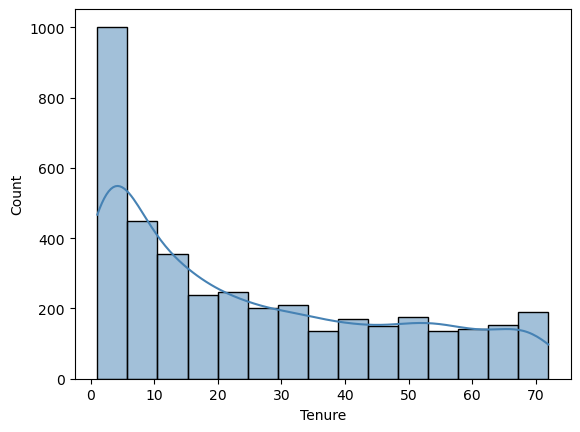

In [27]:
BIN_WIDTH = bin_width(df, 'Tenure')

sns.histplot(df['Tenure'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)

<Axes: xlabel='ChargesMonthly', ylabel='Count'>

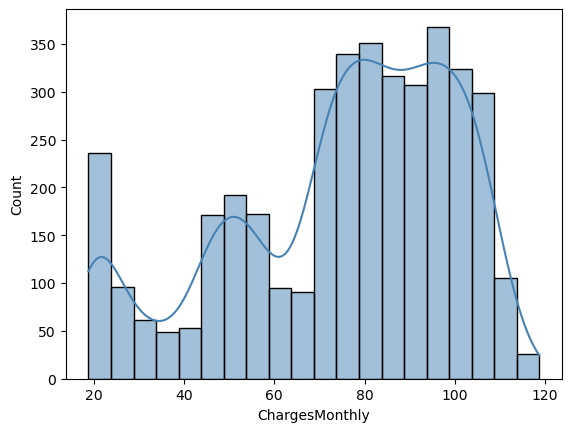

In [28]:
BIN_WIDTH = bin_width(df, 'ChargesMonthly')

sns.histplot(df['ChargesMonthly'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)

<Axes: xlabel='ChargesTotal', ylabel='Count'>

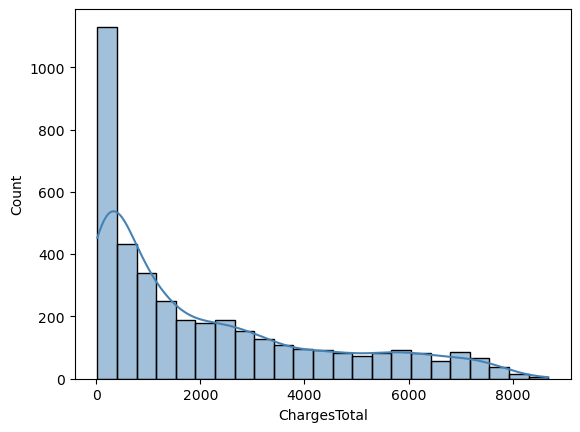

In [29]:
BIN_WIDTH = bin_width(df, 'ChargesTotal')

sns.histplot(df['ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)

In [30]:
df['log_ChargesTotal'] = np.log(df['ChargesTotal'] + 1)

<Axes: xlabel='log_ChargesTotal', ylabel='Count'>

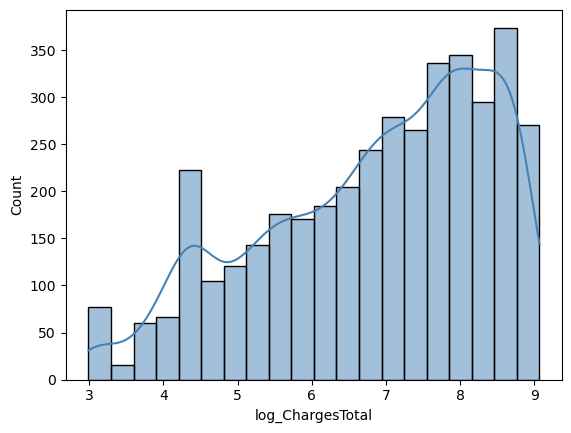

In [31]:
BIN_WIDTH = bin_width(df, 'log_ChargesTotal')

sns.histplot(df['log_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)

In [32]:
df['sqrt_ChargesTotal'] = np.sqrt(df['ChargesTotal'] + 1)

<Axes: xlabel='sqrt_ChargesTotal', ylabel='Count'>

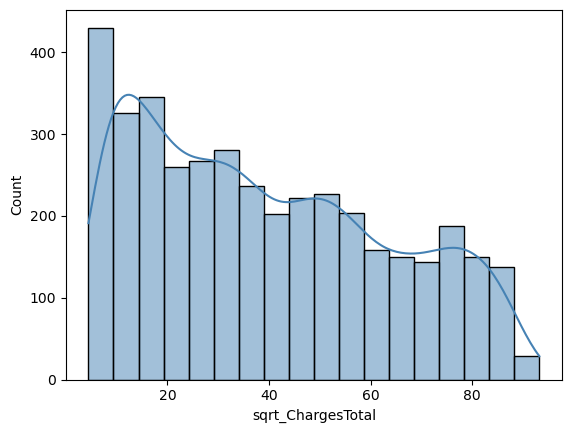

In [33]:
BIN_WIDTH = bin_width(df, 'sqrt_ChargesTotal')

sns.histplot(df['sqrt_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)

In [34]:
scaler = StandardScaler()

In [35]:
df['Z_ChargesTotal'] = scaler.fit_transform(df[['ChargesTotal']])

<Axes: xlabel='Z_ChargesTotal', ylabel='Count'>

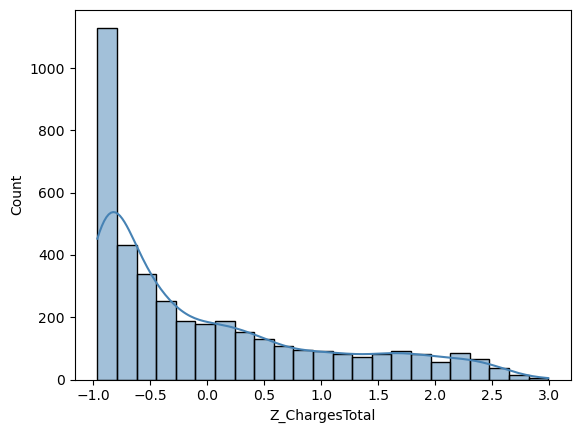

In [36]:
BIN_WIDTH = bin_width(df, 'Z_ChargesTotal')

sns.histplot(df['Z_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)

### Observaciones: Normalización de datos

Es posible observar que ninguna de las transformaciones aplicadas consigue corregir la asimetría positiva de ChargesTotal.
Debido a su naturaleza acumulativa, se puede esperar de este tipo de variables que la mayor concentración de observaciones se encuentre en valores pequeños, teniendo solo valores altos por ejemplo, para un grupo seleccionado de clientes.
En adición, fueron incluidos los registros considerados outliers (clientes de alto valor que abandonaron la empresa), ya que resulta importante conocer que características comparten estos con aquellos de "menor valor", lo que indicará **áreas críticas de mejora para reducir la tasa de Evación *(Churn)***.

Por lo tanto optaré por mantener las variables cuantitativas en su estado original y evaluar si los modelos son capaces de manejarlas correctamente. Caso contrario, aplicaré `MinMaxScaler`

In [37]:
df = df.drop(['log_ChargesTotal', 'sqrt_ChargesTotal', 'Z_ChargesTotal'], axis=1)

In [38]:
#normalizer = MinMaxScaler()

#df['Tenure'] = normalizer.fit_transform(df[['Tenure']])
#df['ChargesMonthly'] = normalizer.fit_transform(df[['ChargesMonthly']])
#df['ChargesTotal'] = normalizer.fit_transform(df[['ChargesTotal']])

In [39]:
df.describe()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
count,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,...,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000
mean,0.505056,0.215369,0.427199,0.233822,0.915066,0.469161,0.301062,0.627149,0.071790,0.251011,...,0.096562,0.691608,0.180485,0.173660,0.460819,0.185035,25.162032,74.844843,2126.464130,0.500000
std,0.500038,0.411130,0.494734,0.423314,0.278819,0.499111,0.458777,0.483624,0.258172,0.433650,...,0.295398,0.461888,0.384640,0.378865,0.498525,0.388375,21.994213,25.315958,2192.434299,0.500063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.800000,18.850000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,56.037500,305.550000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,18.000000,79.875000,1238.150000,0.500000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,42.000000,94.850000,3307.450000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,118.750000,8684.800000,1.000000


In [40]:
df.shape

(3956, 27)

## Correlación entre variables

In [41]:
corr = df.corr()

In [42]:
# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

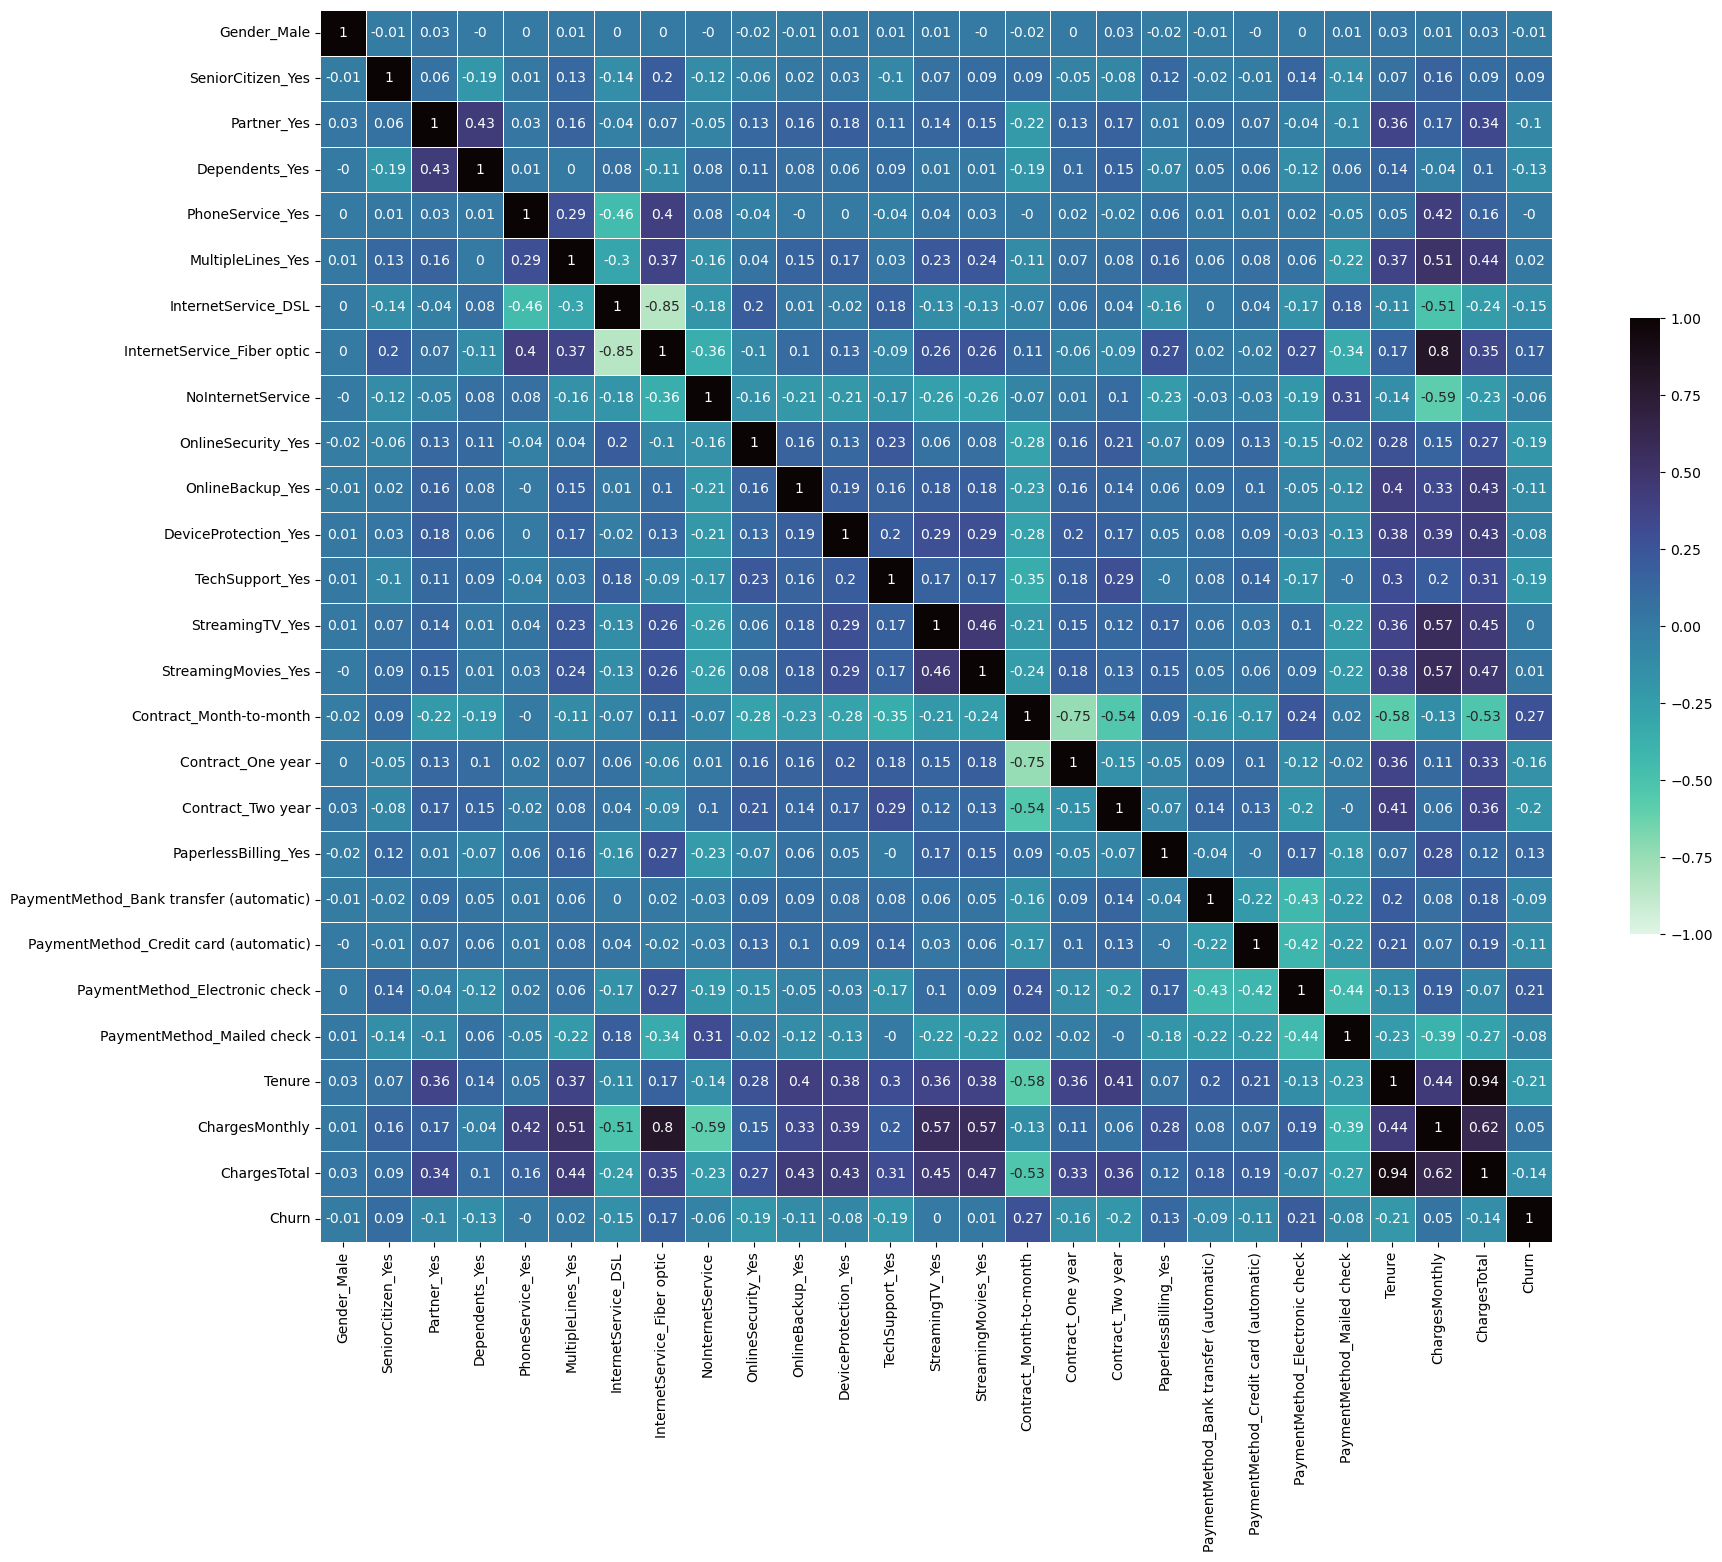

In [43]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr, 2), vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='mako_r')
plt.show()

### ***Nota:***

Debido a que existe una cantidad considerable de variables, para una mejor visualización selecionaré aquellas que tiene una correlación absoluta con la Evasión mayor a 0.07

In [44]:
cols = corr.loc['Churn'].abs()[corr.loc['Churn'].abs() > 0.07].index
corr_selected = corr[cols].loc[cols]  # Subset del DataFrame completo

In [45]:
# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr_selected, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

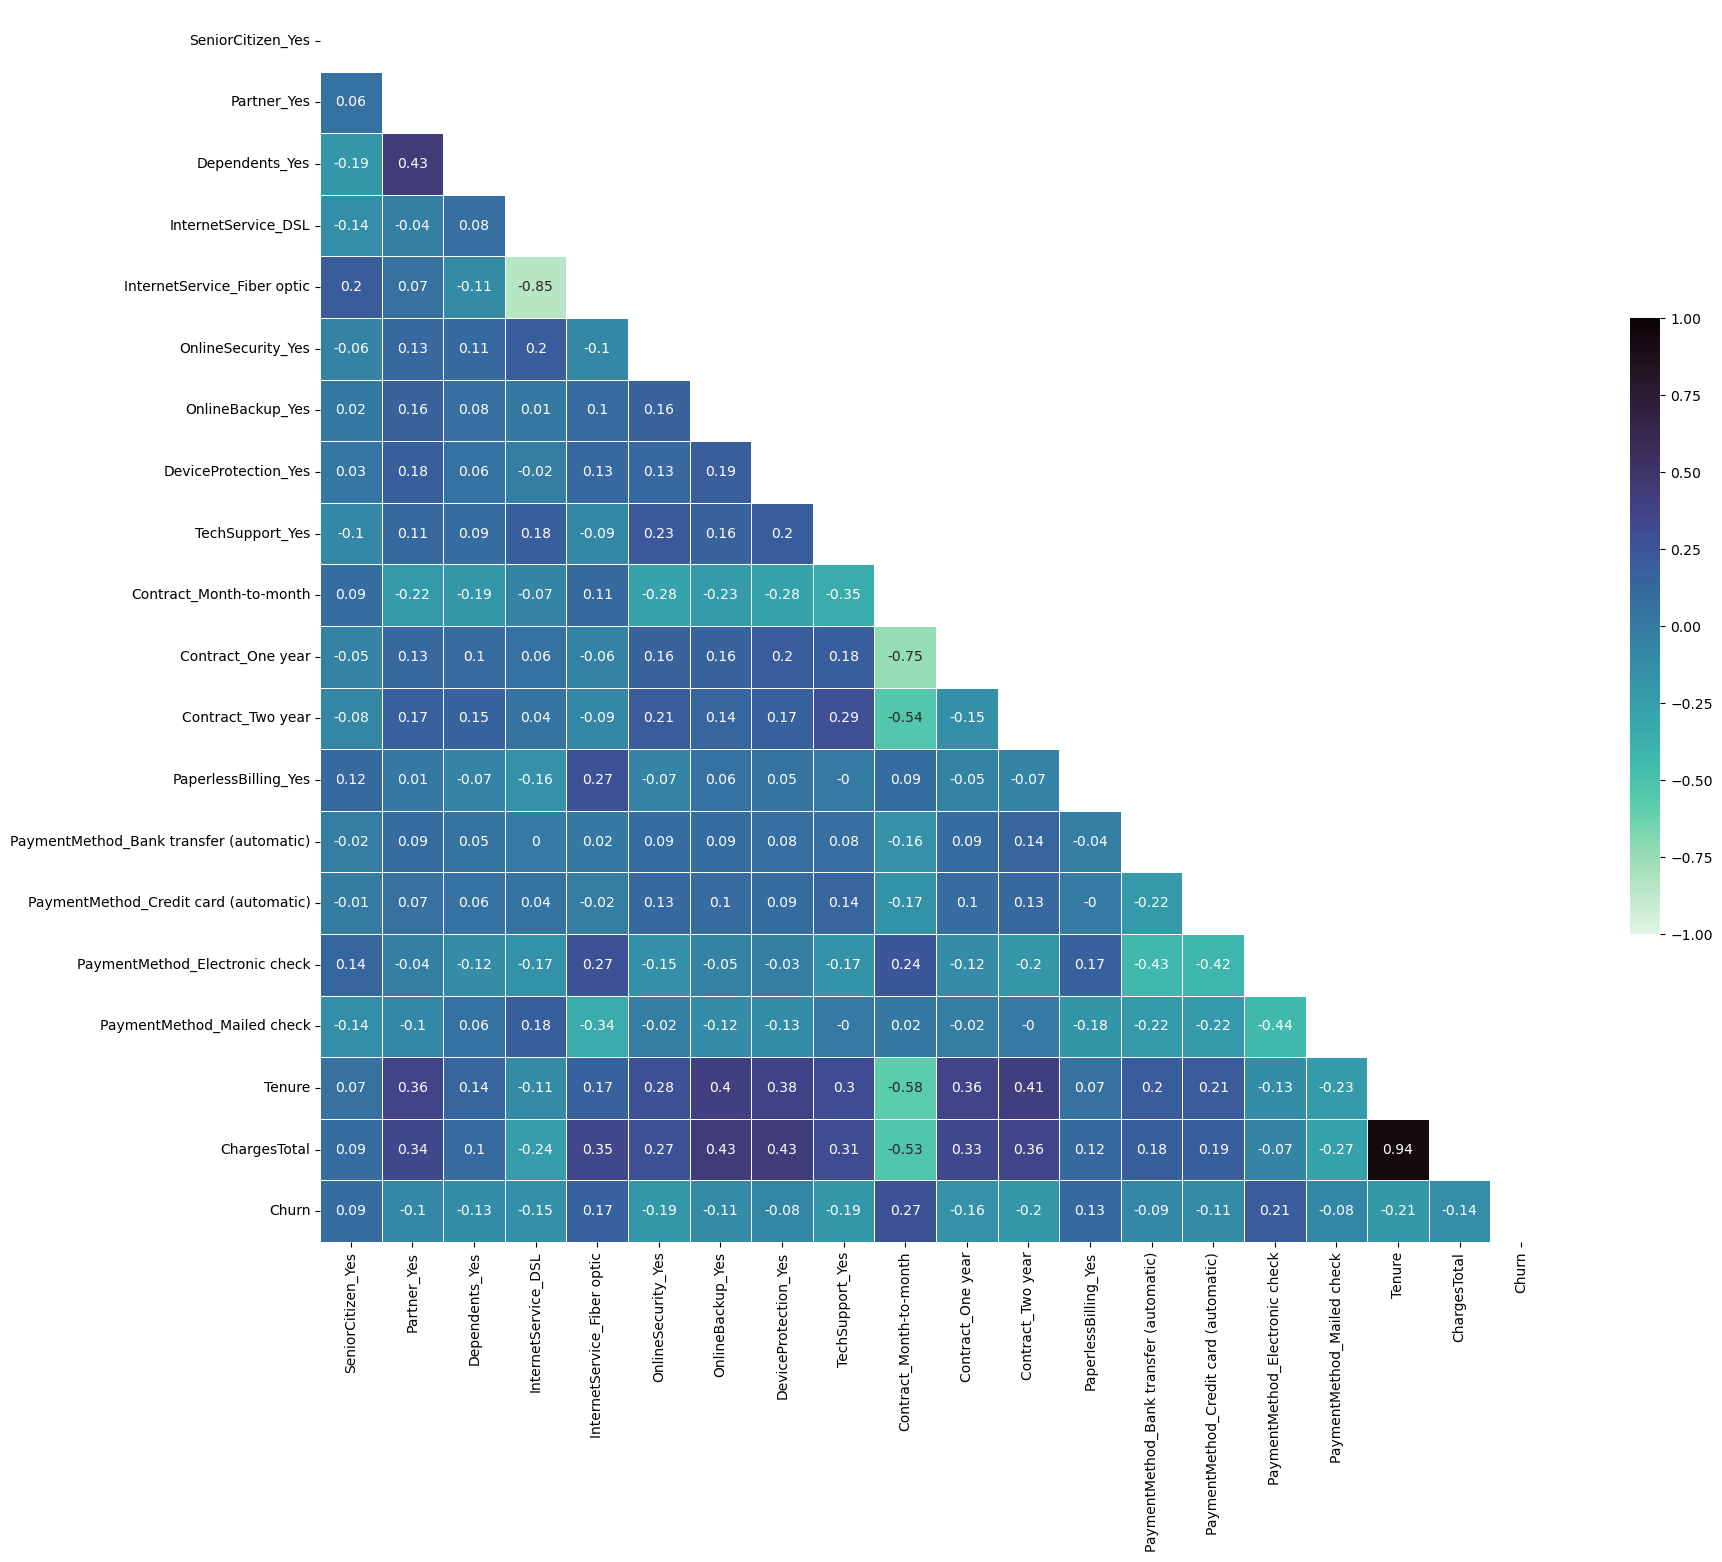

In [46]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr_selected, 2), mask=mascara, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='mako_r')
plt.show()

## Análisis Dirigido

### Evasión (Churn) según Antigüedad (Tenure)

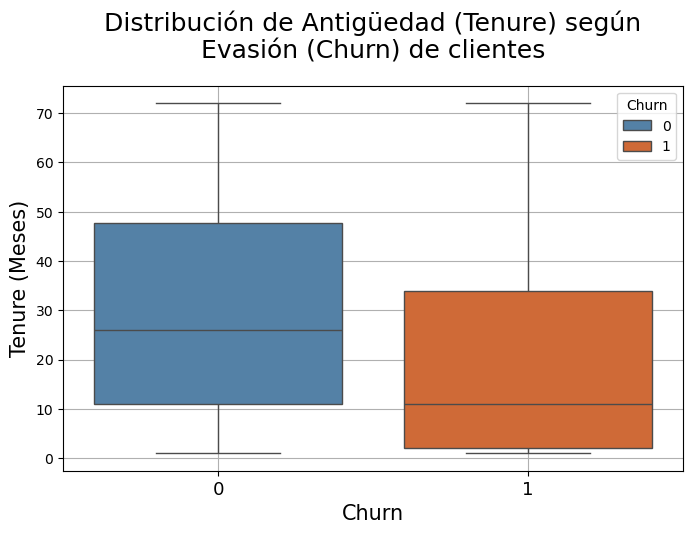

In [47]:
tenure_boxplot = boxplot_churn(df, ycol='Tenure', ylabel='Tenure (Meses)', title_translate='Antigüedad (Tenure)')

In [48]:
df[df['Churn'] == 1].describe()['Tenure']

count    1978.000000
mean       20.508595
std        21.721863
min         1.000000
25%         2.000000
50%        11.000000
75%        34.000000
max        72.000000
Name: Tenure, dtype: float64

### Observaciones: Evasión (Churn) según Antigüedad (Tenure)

Como se pudo observar en la etapa anterior del proyecto, es posible observar la frecuencia de abandono es mayor en las etapas tempranas de la relación del cliente con la empresa, con una **concentración del 50% de abandono** antes del primer año de contrato.

### Evasión (Churn) según Gasto Total (ChargesTotal)

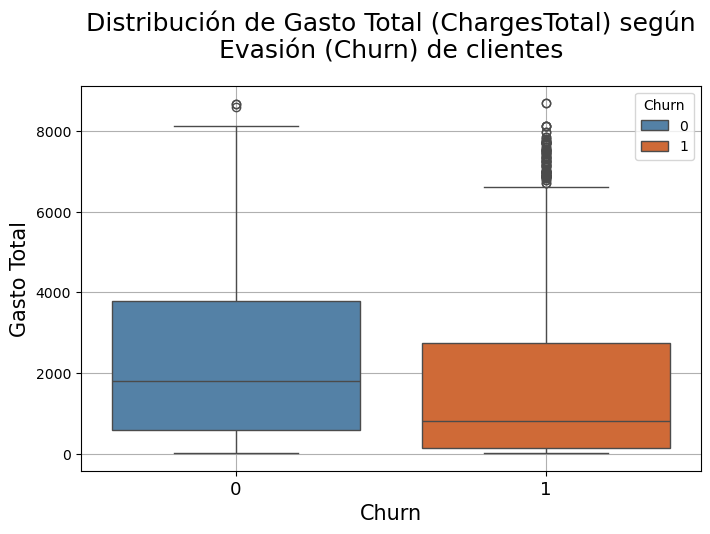

In [49]:
tenure_boxplot = boxplot_churn(df, ycol='ChargesTotal', ylabel='Gasto Total', title_translate='Gasto Total (ChargesTotal)')

### Observaciones: Evasión (Churn) según Gasto Total (ChargesTotal)

Debido a que ChargesTotal es una variable de naturaleza acumulativa, esta fuertemente relacionada con la antigüedad del cliente. Esto se puede observar en el análisis de correlación donde en índice de Pearson entre ambas variables es **0.94**. Esto puede generar redundancia en el modelo, por lo que, se experimentará primero considerando ambas variables, y luego se mantendrá Tenure y ChargesMonthly, ya que la combinación de estas dos variables explican ChargesTotal.

# 4. Modelado de datos

In [50]:
X = df.drop('Churn', axis=1)
y = df['Churn']

## Baseline model

In [51]:
X, X_test, y, y_test = tts(X, y, test_size=0.15, stratify=y, random_state=42)

In [52]:
X.shape

(3362, 26)

In [53]:
X_train, X_val, y_train, y_val = tts(X, y, test_size=0.117, stratify=y, random_state=42)

In [54]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)

In [55]:
baseline_model = DecisionTreeClassifier(random_state=42)

In [56]:
baseline_results = cross_validate(baseline_model, X, y, cv=kf)
baseline_results

{'fit_time': array([0.03927851, 0.03704476, 0.03746438, 0.03808498, 0.03775692,
        0.03866172]),
 'score_time': array([0.00442171, 0.00333548, 0.0029912 , 0.00447345, 0.00442076,
        0.00445628]),
 'test_score': array([0.64527629, 0.65953654, 0.62321429, 0.60357143, 0.63214286,
        0.66071429])}

In [57]:
baseline_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [58]:
baseline_pred = baseline_model.predict(X_val)

In [59]:
print(classification_report(y_val, baseline_pred))

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       197
           1       0.64      0.71      0.67       197

    accuracy                           0.65       394
   macro avg       0.65      0.65      0.65       394
weighted avg       0.65      0.65      0.65       394



In [60]:
confmat = confusion_matrix(y_val, baseline_pred)

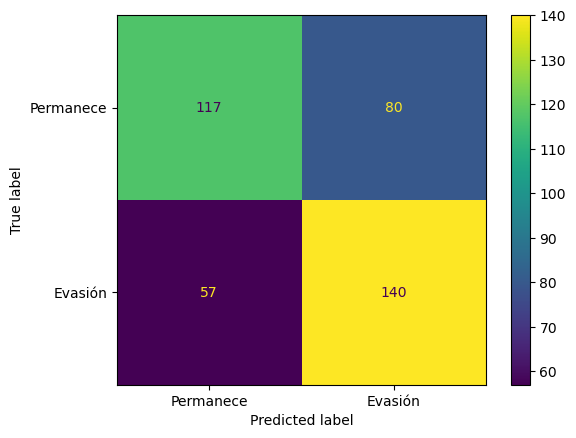

In [61]:
viz_confmat = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['Permanece', 'Evasión'])
viz_confmat.plot()

In [62]:
# Crear una lista para almacenar los resultados de los modelos y poder realizar comparaciones.
results_tracking = []

In [63]:
baseline_results = metricas_generales(baseline_model, X_val, y_val, 'Baseline Model')

In [64]:
baseline_results

{'Model': 'Baseline Model',
 'Accuracy': 0.6523,
 'Precision': 0.6364,
 'Recall': 0.7107,
 'F1-score': 0.6715}

## Observaciones: Baseline Model

El resultado del modelo inicial es bastante aceptable, fue entrenado sin ningún hiperparámetro para utilizarlo como base.
* **Exactitud (Accuracy) = 65.23%**.
$$
Accuracy = \frac{TP + TN}{TP+TN+FP+FN}
$$
* El modelo demuestra un mejor desempeño al identificar correctamente a los clientes que efectivamente abandonan, ya que el **Recall (Sensibilidad)** del modelo tiene un valor de **71.07%**, es decir, el ratio de verdaderos positivos sobre el total de positivos reales:
$$
Recall = \frac{TP}{TP+FN}
$$
* Mientras que la **Precisión (Precision)** tiene un valor de **63.64%**.
$$
Precision = \frac{TP}{TP+FP}
$$
Dado que el objetivo principal es identificar proactivamente a los clientes en riesgo de abandonar, se prioriza el Recall. No obstante, para evitar acciones innecesarias hacia clientes que no se darían de baja, también se considera **el F1-score**, una métrica que combina ambas dimensiones:
$$
\text{F1-score} = 2*\frac{Recall * Precision}{Recall + Precision}
$$

**El objetivo será, por tanto, maximizar la sensibilidad sin sacrificar excesivamente la precisión, para lograr intervenciones eficaces y eficientes.**

In [65]:
results_tracking.append(baseline_results)

In [66]:
# Para comprobar el ajuste del entrenamiento del modelo base:
train_preds = baseline_model.predict(X_train)
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1484
           1       1.00      1.00      1.00      1484

    accuracy                           1.00      2968
   macro avg       1.00      1.00      1.00      2968
weighted avg       1.00      1.00      1.00      2968



Es posible ver que el modelo memorizó el patrón en los datos de entrenamiento, devolviendo 100% en todas las métricas. Sin embargo, al generalizar en datos de validación, alcanzo un 65% de Exactitud.

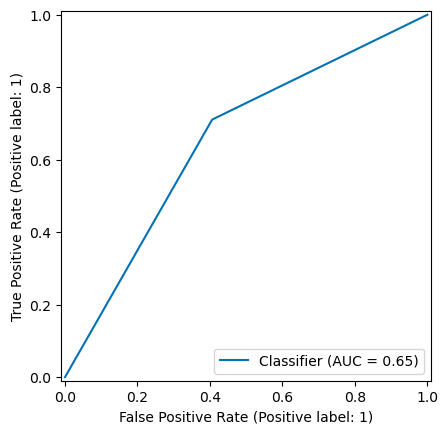

In [67]:
RocCurveDisplay.from_predictions(y_val, baseline_pred);

In [68]:
baseline_model.feature_importances_

array([0.0269438 , 0.01896901, 0.02964582, 0.017463  , 0.00896516,
       0.01580725, 0.00031447, 0.02458551, 0.        , 0.01780934,
       0.01674881, 0.019835  , 0.02161507, 0.01464101, 0.01254986,
       0.04974994, 0.00549268, 0.        , 0.01885588, 0.00696659,
       0.01157127, 0.01955595, 0.0094518 , 0.22195704, 0.2083891 ,
       0.20211663])

In [69]:
baseline_imporatences = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.round(baseline_model.feature_importances_, 4)}).sort_values('Importance', ascending=False)
baseline_imporatences

,Feature,Importance
23,Tenure,0.2220
24,ChargesMonthly,0.2084
25,ChargesTotal,0.2021
15,Contract_Month-to-month,0.0497
2,Partner_Yes,0.0296
0,Gender_Male,0.0269
7,InternetService_Fiber optic,0.0246
12,TechSupport_Yes,0.0216
11,DeviceProtection_Yes,0.0198
21,PaymentMethod_Electronic check,0.0196


# Random Forest Classifier

## RandomForest 1 - MaxDepth = 10

In [70]:
modelo_1 = RandomForestClassifier(max_depth=10, random_state=42) 

In [71]:
modelo_1.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [72]:
modelo_1_preds = modelo_1.predict(X_val)
print(classification_report(y_val, modelo_1_preds))

              precision    recall  f1-score   support

           0       0.70      0.65      0.68       197
           1       0.67      0.72      0.69       197

    accuracy                           0.69       394
   macro avg       0.69      0.69      0.68       394
weighted avg       0.69      0.69      0.68       394



In [73]:
modelo_1_results = metricas_generales(modelo_1, X_val, y_val, 'RandomForest 1')
modelo_1_results

{'Model': 'RandomForest 1',
 'Accuracy': 0.6853,
 'Precision': 0.6746,
 'Recall': 0.7157,
 'F1-score': 0.6946}

In [74]:
results_tracking.append(modelo_1_results)

## Observaciones RandomForest 1

Este modelo de ensamble consigue mejorar levemente el Recall (Sensibilidad) en un 0.5%. Pero con una mejor generalización.

* La exactitud del modelo mejora aproximadamente **3.3%**
* La Precisión del modelo mejora aproximadamente **4%**

Como se mencionó anteriormente, el **F1-score** es una métrica que combina las dimensiones de Recall y Precisión. Al obtener, mejora en ambas métricas, podemos observar como este también obtiene una mejora de aproximadamente **2.3%**.

Por lo tanto, el ensamble de diversos árboles de decisión permite una mejor generalización del patrón contenido en los datos por parte del modelo. Por lo que se buscará mejorar este modelo.

In [75]:
columnas = X_train.columns

In [76]:
importances = np.round(modelo_1.feature_importances_, 4)

In [77]:
len(columnas), len(importances)

(26, 26)

In [78]:
modelo_1_importances = pd.DataFrame({'Feature': columnas, 'Importance': importances}).sort_values('Importance', ascending=False)
modelo_1_importances

,Feature,Importance
23,Tenure,0.2085
25,ChargesTotal,0.1889
24,ChargesMonthly,0.1288
15,Contract_Month-to-month,0.0605
21,PaymentMethod_Electronic check,0.0389
7,InternetService_Fiber optic,0.0281
9,OnlineSecurity_Yes,0.0266
12,TechSupport_Yes,0.0265
18,PaperlessBilling_Yes,0.0252
3,Dependents_Yes,0.0214


Como se ve en el análisis de importancia de características, el modelo determina que la Antigüedad (Tenure) es la principal razón para determinar la Evasión (Churn) del cliente.
Sin embargo, en el análisis de correlación, SeniorCitizen, por ejemplo, tiene un índice de correlación con la Evasión de 0.09, mientras que Gender apenas de 0.01. En la etapa previa, se observó en el análisis de datos que Género presentaba una distribución simétrica en cuanto a la Evasión, lo cual sugería que esta característica no era relevante a la hora de preveer la variable objetivo.
Si bien el objetivo de Machine Learning es dejar que el modelo encuentre las reglas apropiadas para resolver el problema en cuestión, analizaré el desempeño de un nuevo modelo con las variables seleccionadas en el segundo análisis de correlación, agregando a estas la variable ChargesMonthly.

## Random Forest 2 - Max Depth 10 - Corr_selected Features + ChargesMonthly

In [79]:
corr_selected.columns

Index(['SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure', 'ChargesTotal', 'Churn'],
      dtype='object')

In [80]:
rf2_cols = ['SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure', 'ChargesMonthly', 'ChargesTotal']

In [81]:
modelo_2 = RandomForestClassifier(max_depth=10, random_state=42)

In [82]:
modelo_2.fit(X_train[rf2_cols], y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [83]:
modelo_2_preds = modelo_2.predict(X_val[rf2_cols])
print(classification_report(y_val, modelo_2_preds))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       197
           1       0.68      0.71      0.69       197

    accuracy                           0.69       394
   macro avg       0.69      0.69      0.69       394
weighted avg       0.69      0.69      0.69       394



In [84]:
print(classification_report(y_val, modelo_1_preds))

              precision    recall  f1-score   support

           0       0.70      0.65      0.68       197
           1       0.67      0.72      0.69       197

    accuracy                           0.69       394
   macro avg       0.69      0.69      0.68       394
weighted avg       0.69      0.69      0.68       394



In [85]:
importances = np.round(modelo_2.feature_importances_, 4)
modelo_2_importances = pd.DataFrame({'Feature': rf2_cols, 'Importance': importances}).sort_values('Importance', ascending=False)
modelo_2_importances

,Feature,Importance
17,Tenure,0.2310
19,ChargesTotal,0.2086
18,ChargesMonthly,0.1395
15,PaymentMethod_Electronic check,0.0479
9,Contract_Month-to-month,0.0443
4,InternetService_Fiber optic,0.0375
5,OnlineSecurity_Yes,0.0291
8,TechSupport_Yes,0.0274
12,PaperlessBilling_Yes,0.0272
11,Contract_Two year,0.0249


In [86]:
modelo_2_results = metricas_generales(modelo_2, X_val[rf2_cols], y_val, 'RandomForest 2')

results_tracking.append(modelo_2_results)

## Observaciones: Random Forest 2 - Max Depth 10 - Corr_selected Features + ChargesMonthly

No se produjo ninguna mejora al utilizar solo las variables determinadas por el análisis de correlación.

## Random Forest 3 - Max Depth = 10 - Corr_selected features (reemplazar ChargesTotal por ChargesMonthly)

In [87]:
rf3_cols = ['SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure', 'ChargesMonthly']

In [88]:
modelo_3 = RandomForestClassifier(max_depth=10, random_state=42)

In [89]:
modelo_3.fit(X_train[rf3_cols], y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [90]:
modelo_3_preds = modelo_3.predict(X_val[rf3_cols])
print(classification_report(y_val, modelo_3_preds))

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       197
           1       0.66      0.70      0.68       197

    accuracy                           0.67       394
   macro avg       0.67      0.67      0.67       394
weighted avg       0.67      0.67      0.67       394



In [91]:
modelo_3_results = metricas_generales(modelo_3, X_val[rf3_cols], y_val, 'RandomForest 3')

results_tracking.append(modelo_3_results)

## Observaciones: Random Forest 3 - Max Depth = 10 - Corr_selected features (reemplazar ChargesTotal por ChargesMonthly)

El uso de la variable `ChargesMonthly` en reemplazo de `ChargesTotal` genera perdida en las metricas del modelo. Por lo que, a continuación se determinarán las variables utilizando la arquitectura del RandomForest 1 para luego ajustar los hiperparámetros de este.

## Feature Selection

In [92]:
resultados = []

ct_features = [i if i != 0 else 1 for i in range(0, 26, 5)]

for i in ct_features:
    model_features = RandomForestClassifier(max_depth=10, random_state=42)
    selected_features = modelo_1_importances['Feature'].values[:i]
    X_train_sel = X_train[selected_features]
    X_val_sel = X_val[selected_features]
    model_features.fit(X_train_sel, y_train)
    metricas = metricas_generales(model_features, X_val_sel, y_val, f'Features: {i}')
    resultados.append(metricas)

pd.DataFrame(resultados)

,Model,Accuracy,Precision,Recall,F1-score
0,Features: 1,0.6269,0.6543,0.5381,0.5905
1,Features: 5,0.6980,0.6912,0.7157,0.7032
2,Features: 10,0.6827,0.6782,0.6954,0.6867
3,Features: 15,0.6827,0.6731,0.7107,0.6914
4,Features: 20,0.6853,0.6714,0.7259,0.6976
5,Features: 25,0.6675,0.6557,0.7056,0.6797


Teniendo en cuenta que estamos priorizando el Recall, ya que el objetivo es identificar aquellos clientes potenciales a cancelar sus servicios, el modelo que mejor se desempeña utiliza las 20 características más importantes.
El siguiente en terminos de Recall es el modelo que utiliza solo las 5 características más importantes. Con un recall aproximadamente un 1% más bajo, pero con una precisión de casi 2% más alta en relación al modelo mencionado anteriormente. Por lo que, en los siguiente será encontrar los hiperparámetros que mejor se ajusten a ambos casos, para comparar los resultados de ambos modelos.

## Fine Tunning - Grid Search

Se ejecutará un Grid Search para definir los hiperparámetros que mejor se ajusten al modelo, una vez obtenidos, se entrenará el mejor modelo posible para evaluar sus resultados.

## RandomForest 4

In [93]:
features_5 = modelo_1_importances['Feature'].values[:5]

In [94]:
#param_grid = {
#    'max_depth': [5, 10, 15, 20],
#    'min_samples_leaf': [1, 2, 3, 5],
#    'min_samples_split': [2, 4, 6, 10],
#    'n_estimators': [100, 150, 200, 250]
#}

#model_grid_5f = GridSearchCV(RandomForestClassifier(random_state=42),
#                          param_grid=param_grid, scoring='recall',
#                          cv=kf)


#model_grid_5f.fit(X_train[features_5], y_train)

In [95]:
#model_grid_5f.best_params_

**Resultado de Grid Search con 5 Features:**


{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

Se conservará codigo en caso de necesitar reejecutar el script con los mejores hiperparámetros para evitar la necesidad de correr el GridSearch ya que toma cierto tiempo para su ejecución

In [96]:
modelo_4 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=150)
modelo_4.fit(X_train[features_5], y_train)
modelo_4_preds = modelo_4.predict(X_val[features_5])
modelo_4_results = metricas_generales(modelo_4, X_val[features_5], y_val, 'RandomForest 4')
results_tracking.append(modelo_4_results)
print(classification_report(y_val, modelo_4_preds))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       197
           1       0.68      0.70      0.69       197

    accuracy                           0.68       394
   macro avg       0.68      0.68      0.68       394
weighted avg       0.68      0.68      0.68       394



In [97]:
#model_grid_5f_preds = model_grid_5f.predict(X_val[features_5])

#print(classification_report(y_val, model_grid_5f_preds))

In [98]:
#model_grid_5f_results = metricas_generales(model_grid_5f, X_val[features_5], y_val, 'RandomForestGS - 5 Features')

In [99]:
#results_tracking.append(model_grid_5f_results)

## RandomForest 5

In [100]:
features_20 = modelo_1_importances['Feature'].values[:20]

In [101]:
#model_grid_20f = GridSearchCV(RandomForestClassifier(random_state=42),
#                          param_grid=param_grid, scoring='recall',
#                          cv=kf)


#model_grid_20f.fit(X_train[features_20], y_train)

In [102]:
#model_grid_20f.best_params_

**Resultado de Grid Search CV con 20 features:**

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

In [103]:
modelo_5 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=100)
modelo_5.fit(X_train[features_20], y_train)
modelo_5_preds = modelo_5.predict(X_val[features_20])
modelo_5_results = metricas_generales(modelo_5, X_val[features_20], y_val, 'RandomForest 5')
results_tracking.append(modelo_5_results)
print(classification_report(y_val, modelo_5_preds))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67       197
           1       0.67      0.72      0.69       197

    accuracy                           0.68       394
   macro avg       0.68      0.68      0.68       394
weighted avg       0.68      0.68      0.68       394



In [104]:
#model_grid_20f_preds = model_grid_20f.predict(X_val[features_20])

#print(classification_report(y_val, model_grid_20f_preds))

In [105]:
#model_grid_20f_results = metricas_generales(model_grid_20f, X_val[features_20], y_val, 'RandomForestGS - 20 Features')
#results_tracking.append(model_grid_20f_results)

In [106]:
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6523,0.6364,0.7107,0.6715
1,RandomForest 1,0.6853,0.6746,0.7157,0.6946
2,RandomForest 2,0.6878,0.6796,0.7107,0.6948
3,RandomForest 3,0.6701,0.6603,0.7005,0.6798
4,RandomForest 4,0.6827,0.6782,0.6954,0.6867
5,RandomForest 5,0.6827,0.6714,0.7157,0.6929


Despues de entrenar 5 modelos distintos, es posible observar que el que tiene mejor desempeño es el modelo RandomForestGS - 5 features.
Esto indica que el modelo más simple, utilizando solo 5 variables, consiguió la mejor Exactitud, Precisión y Recall entre los 5 modelos entrenados.

In [107]:
print(f'Variables utilizadas por el modelo que mejor se desempeña: {rf2_cols}')

Variables utilizadas por el modelo que mejor se desempeña: ['SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'Tenure', 'ChargesMonthly', 'ChargesTotal']


In [148]:
with open(MODELS_PATH / 'best_randomforest.pkl', 'wb') as f:
    pickle.dump(modelo_2, f)

# Conclusiones Random Forest

# FALTA ESCRIBIR CONCLUSIONES

# Logistic Regresion

A diferencia del modelo RandomForest, la Regresión Logística es sensible a outliers y a la escala de los datos.
Ya que la mayoría de los features presentes  en el dataset corresponden a variables categóricas binarias (valores de 0 o 1), será necesario reescalar las variables numéricas para que el modelo no otorgue mayor importancia debido a la magnitud de las mismas.

In [109]:
from sklearn.preprocessing import RobustScaler

In [110]:
robust_scaler = RobustScaler()

In [111]:
X_scaled = df.drop('Churn', axis=1)
y_scaled = df['Churn']

In [112]:
x_num = ['Tenure', 'ChargesMonthly', 'ChargesTotal']

X_lr_num = X_scaled[x_num]

X_lr_num = robust_scaler.fit_transform(X_lr_num)

In [113]:
X_lr_num

array([[ 1.45945946,  0.95523349,  2.45053133],
       [ 1.45945946,  0.96940419,  2.47574869],
       [ 1.45945946,  1.00161031,  2.47653153],
       ...,
       [ 0.16216216, -0.09726248,  0.15808321],
       [-0.08108108,  0.5468599 ,  0.08857723],
       [ 0.27027027,  0.66537842,  0.58008261]])

In [114]:
X_scaled[['Tenure_scaled', 'ChargesMonthly_scaled', 'ChargesTotal_scaled']] = X_lr_num

In [115]:
X_scaled = X_scaled.drop(['Tenure', 'ChargesMonthly', 'ChargesTotal'], axis=1)

In [116]:
X_scaled.head()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure_scaled,ChargesMonthly_scaled,ChargesTotal_scaled
0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.459459,0.955233,2.450531
1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.459459,0.969404,2.475749
2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.459459,1.001610,2.476532
3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.459459,0.783897,2.241497
4,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.459459,0.791626,2.239931


In [117]:
X_scaled, X_scaled_test, y_scaled, y_scaled_test = tts(X_scaled, y_scaled, test_size=0.1, random_state=42)

In [118]:
X_scaled_train, X_scaled_val, y_scaled_train, y_scaled_val = tts(X_scaled, y_scaled, test_size=0.135, random_state=42)

## LogisticRegression 1

In [119]:
from sklearn.linear_model import LogisticRegression

In [120]:
lr_1 = LogisticRegression(random_state=42)

In [121]:
lr_1.fit(X_scaled_train, y_scaled_train)

LogisticRegression(random_state=42)

In [122]:
lr_1_preds = lr_1.predict(X_scaled_val)

In [123]:
lr_1_results = metricas_generales(lr_1, X_scaled_val, y_scaled_val, 'LogisticRegression 1')
pd.DataFrame([lr_1_results])

,Model,Accuracy,Precision,Recall,F1-score
0,LogisticRegression 1,0.6715,0.6595,0.7449,0.6996


In [124]:
results_tracking.append(lr_1_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6523,0.6364,0.7107,0.6715
1,RandomForest 1,0.6853,0.6746,0.7157,0.6946
2,RandomForest 2,0.6878,0.6796,0.7107,0.6948
3,RandomForest 3,0.6701,0.6603,0.7005,0.6798
4,RandomForest 4,0.6827,0.6782,0.6954,0.6867
5,RandomForest 5,0.6827,0.6714,0.7157,0.6929
6,LogisticRegression 1,0.6715,0.6595,0.7449,0.6996


## Observaciones: Resultados LogisticRegression 1

* El modelo **LogisticRegression 1** logró un **Recall = 0.7449**, el más alto de todos, superando al baseline (0.7107) y a los Random Forests.

* A pesar de que la **Precisión cae ligeramente (de ~0.67 a 0.6595)**, la mejora en Recall es prioritaria en este caso, ya que **interesa identificar correctamente a los clientes que se dan de baja**, aún a costa de incluir algunos falsos positivos.

* El **F1-score de 0.6996** se mantiene en el rango competitivo de los mejores modelos (~0.69–0.70), lo que valida este trade-off como aceptable.


Para mayor profundidad, se evaluarán los coeficientes del modelo, para determinar que variables son las que más influyen en el abandono, y así reducir la dimensionalidad del modelo eliminando variables sin valor predictivo claro, y reentrenar utilizando solo las variables más relevantes.

In [125]:
features = X_scaled.columns

In [126]:
coeficients = lr_1.coef_
coeficients

array([[-0.00796205,  0.07790652, -0.03151994, -0.22561038, -0.68993957,
         0.143805  , -0.19680248,  0.29465681, -0.11237939, -0.3786019 ,
        -0.22734024, -0.08930969, -0.40027677,  0.11401875,  0.06574909,
         0.50188412, -0.07636235, -0.44004683,  0.30323668, -0.04857143,
        -0.10280226,  0.28428786, -0.14743923, -2.12799338, -0.23181136,
         1.62913193]])

In [127]:
lr_1_coeficients = pd.DataFrame({'Feature': features, 'Coeficiente': coeficients[0]}).sort_values('Coeficiente', ascending=False)
intercept = pd.DataFrame({'Feature': ['Intercept'], 'Coeficiente': [lr_1.intercept_[0]]})
lr_1_coeficients = pd.concat([lr_1_coeficients, intercept], ignore_index=True)
lr_1_coeficients

,Feature,Coeficiente
0,ChargesTotal_scaled,1.629132
1,Contract_Month-to-month,0.501884
2,PaperlessBilling_Yes,0.303237
3,InternetService_Fiber optic,0.294657
4,PaymentMethod_Electronic check,0.284288
5,MultipleLines_Yes,0.143805
6,StreamingTV_Yes,0.114019
7,SeniorCitizen_Yes,0.077907
8,StreamingMovies_Yes,0.065749
9,Gender_Male,-0.007962


## Observaciones: Coeficientes LogisticRegression 1

### Variables Numéricas

Ha de tenerse en cuenta que las variables numéricas han sido escaladas, por lo que su interpretación es por cambio en unidades escaladas *(RobustScaler)*. Aun así, la dirección e importancia relativa son claras:

* **Tenure_scaled = -2.13:**

Es el coeficiente más fuerte en valor absoluto, y negativo, lo que indica que a **mayor antigüedad (tenure), menor probabilidad de churn**.
Tiene más peso que ninguna otra variable, lo cual es coherente: clientes más fieles abandonan menos.
O visto desde otro punto, los clientes tienden a abandonar en las etapas tempranas de la relación con la empresa.

* **ChargesMonthly_scaled = -0.23:**

Cuanto mayor es el pago mensual, ligeramente menor es la probabilidad de churn. Esto puede parecer contraintuitivo, pero podría reflejar que los clientes con servicios más caros están más comprometidos.

**ChargesTotal_scaled = +1.63:**

Aquí surge una contradicción: el coeficiente positivo indica que los clientes que han pagado mucho tienen mayor probabilidad de churn. Pero dada la naturaleza acumulativa de esta variable, los clientes que han pagado mucho tienen por ende mayor antigüedad.
Esto posiblemente esté relacionado a los outliers observados anteriormente, que corresponden a clientes de alto valor que están abandonando.

Esto, como se observó en la etapa anterior, es un dato clave para acciones comerciales: clientes que ya generaron muchos ingresos, pero están por irse requieren especial atención.

### Variables Categóricas

* **Contract_Month-to-month = +0.50:**

Los clientes con contrato mes a mes son mucho más propensos a irse.

* **PaperlessBilling_Yes = +0.30:**

Menos fidelidad de los clientes digitalizados

* **InternetService_Fiber optic = +0.29:**

Tener fibra óptica se asocia a más churn, lo cual es consistente con lo observado en la etapa anterior del proyecto donde se concluyó que existía insatisfacción con este servicio.

* **PaymentMethod_Electronic check = +0.28:**

Posible problema con el servicio de factura electrónica.

* **Contract_Two year = -0.44:**

Los clientes que optan por contratos de dos años tienen menor tendencia a abandonar, lo cual es lógico.

* **TechSupport_Yes = -0.40, OnlineSecurity_Yes = -0.38:**

Tener servicios de soporte o seguridad reduce el churn. Esto confirma también uno de los análisis de la etapa anterior donde se determinó que servicios extra contribuían a mayor retención.

* **PhoneService_Yes = -0.69:**

Clientes que cuentan con servicio telefónico tienden a quedarse.

* **Dependents_Yes = -0.23:**

Esto resulta interesante, ya que a diferencia de lo analizado en la etapa anterior, indica que los clientes que tienen personas a cargo tienen menor probabilidad de abandono.

* **PaymentMethod_Mailed check = -0.15:**

Los clientes con facturación por correo tienden a ser más fieles, lo que resalta la posibilidad de que exista insatisfacción con los servicios digitales.

* **Gender_Male = -0.007**

A diferencia de los arboles de decisión que dieron cierta importancia a esta variable, en el caso de la Regresión Logística, esta variable es despreciable ya que su coeficiente resulta cercano a 0, lo cual esta en armonía con lo analizado en la etapa anterior del proyeco donde se observó que el género no parecía ser un determinante de Evasión (Churn)

## LogisticRegression 2 - Feature Selection

Se seleccionarán las variables que tengan un coeficiente mayor a 0.2 en valor absoluto, para reducir la dimensionalidad del modelo y evaluar sus resultados.

In [128]:
lr_1_principales_coeficientes = lr_1_coeficients[lr_1_coeficients['Coeficiente'].abs() > 0.2]
lr_1_principales_coeficientes

,Feature,Coeficiente
0,ChargesTotal_scaled,1.629132
1,Contract_Month-to-month,0.501884
2,PaperlessBilling_Yes,0.303237
3,InternetService_Fiber optic,0.294657
4,PaymentMethod_Electronic check,0.284288
18,Dependents_Yes,-0.225610
19,OnlineBackup_Yes,-0.227340
20,ChargesMonthly_scaled,-0.231811
21,OnlineSecurity_Yes,-0.378602
22,TechSupport_Yes,-0.400277


In [129]:
selected_features = lr_1_principales_coeficientes['Feature'].values
selected_features

array(['ChargesTotal_scaled', 'Contract_Month-to-month',
       'PaperlessBilling_Yes', 'InternetService_Fiber optic',
       'PaymentMethod_Electronic check', 'Dependents_Yes',
       'OnlineBackup_Yes', 'ChargesMonthly_scaled', 'OnlineSecurity_Yes',
       'TechSupport_Yes', 'Contract_Two year', 'PhoneService_Yes',
       'Tenure_scaled'], dtype=object)

In [130]:
cv_results = cross_validate(LogisticRegression(random_state=42), X_scaled[selected_features], y_scaled, scoring='recall', cv=kf)
cv_results

{'fit_time': array([0.02756548, 0.03059268, 0.02860355, 0.02862239, 0.03043675,
        0.03098226]),
 'score_time': array([0.00717759, 0.00812268, 0.00821376, 0.00720143, 0.00786686,
        0.00775218]),
 'test_score': array([0.74257426, 0.70877193, 0.78350515, 0.70926518, 0.73529412,
        0.76923077])}

In [131]:
cv_results['test_score'].mean()

0.7414402340810263

In [132]:
lr_2 = LogisticRegression(random_state=42)

lr_2.fit(X_scaled_train[selected_features], y_scaled_train)

lr_2_results = metricas_generales(lr_2, X_scaled_val[selected_features], y_scaled_val, 'LogisticRegression 2')
results_tracking.append(lr_2_results)

In [133]:
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6523,0.6364,0.7107,0.6715
1,RandomForest 1,0.6853,0.6746,0.7157,0.6946
2,RandomForest 2,0.6878,0.6796,0.7107,0.6948
3,RandomForest 3,0.6701,0.6603,0.7005,0.6798
4,RandomForest 4,0.6827,0.6782,0.6954,0.6867
5,RandomForest 5,0.6827,0.6714,0.7157,0.6929
6,LogisticRegression 1,0.6715,0.6595,0.7449,0.6996
7,LogisticRegression 2,0.6757,0.6631,0.7490,0.7034


## Observaciones: Resultados LogisticRegression 2 - Selected Features

Al establecer un umbral para el valor de los coeficientes del primer modelo de Regresión Logistica, se seleccionaron los siguientes features:

* ChargesTotal_scaled
* Contract_Month-to-month
* PaperlessBilling_Yes
* InternetService_Fiber optic
* PaymentMethod_Electronic check
* Dependents_Yes
* OnlineBackup_Yes
* ChargesMonthly_scaled
* OnlineSecurity_Yes
* TechSupport_Yes
* Contract_Two year
* PhoneService_Yes
* Tenure_scaled

Esta selección permitió una reducción de dimensionalidad, que se tradujo en una mejora en todas las métricas evaluadas con respecto al modelo completo:

* **Accuracy, Precision, Recall y F1-score mejoraron, lo que indica una mejor capacidad de generalización sobre los datos de validación.**

* **El nuevo modelo (`LogisticRegression 2`) es más simple, menos propenso al sobreajuste.**

En resumen, se logró construir un modelo más eficiente y robusto, sin sacrificar desempeño predictivo, priorizando la métrica de **Recall**, clave en el contexto de Evasión (Churn) de clientes.

## LogisticRegression 3 - Penalty Lasso (L1)

Ya que la selección de variables ha sido realizada manualmente, al seleccionar un umbral arbitrario para los coeficientes de un valor absoluto de 0.2, se llevará a cabo el entrenamiento de otro modelo de Regresión Logística utilizando la regularización Lasso (L1), que penaliza aquellas variables que no aportan poder predictivo al modelo, teniendo la capacidad de llevar dichos coeficientes a 0.

In [134]:
cv_results = cross_validate(LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42),X_scaled, y_scaled, scoring='recall', cv=kf)
cv_results

{'fit_time': array([0.0212009 , 0.03988743, 0.05823541, 0.05476928, 0.05184555,
        0.0555613 ]),
 'score_time': array([0.00199389, 0.00672841, 0.00780106, 0.00622678, 0.00775385,
        0.00669503]),
 'test_score': array([0.74917492, 0.71929825, 0.76632302, 0.70607029, 0.7124183 ,
        0.72377622])}

In [135]:
cv_results['test_score'].mean()

0.7295101665217537

In [136]:
lr_3 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)

lr_3.fit(X_scaled_train, y_scaled_train)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6523,0.6364,0.7107,0.6715
1,RandomForest 1,0.6853,0.6746,0.7157,0.6946
2,RandomForest 2,0.6878,0.6796,0.7107,0.6948
3,RandomForest 3,0.6701,0.6603,0.7005,0.6798
4,RandomForest 4,0.6827,0.6782,0.6954,0.6867
5,RandomForest 5,0.6827,0.6714,0.7157,0.6929
6,LogisticRegression 1,0.6715,0.6595,0.7449,0.6996
7,LogisticRegression 2,0.6757,0.6631,0.7490,0.7034
8,LogisticRegression 3,0.6798,0.6655,0.7571,0.7083


In [138]:
coeficientes_lr3 = lr_3.coef_[0]
coeficientes_lr3 = pd.DataFrame({'Feature': features, 'Coeficiente': coeficientes_lr3}).sort_values('Coeficiente', ascending=False)
coeficientes_lr3

,Feature,Coeficiente
25,ChargesTotal_scaled,1.754091
15,Contract_Month-to-month,0.580557
21,PaymentMethod_Electronic check,0.379953
18,PaperlessBilling_Yes,0.303007
7,InternetService_Fiber optic,0.198514
5,MultipleLines_Yes,0.114533
1,SeniorCitizen_Yes,0.076544
13,StreamingTV_Yes,0.060510
19,PaymentMethod_Bank transfer (automatic),0.040978
14,StreamingMovies_Yes,0.011313


In [ ]:
lr_3_results = metricas_generales(lr_3, X_scaled_val, y_scaled_val, 'LogisticRegression 3')
results_tracking.append(lr_3_results)
pd.DataFrame(results_tracking)

## Observaciones: Resultados LogisticRegression 3 - Penalty Lasso (L1)

Al comparar el modelo con selección manual de variables mediante un umbral arbitrario (LogisticRegression 2) con el modelo entrenado utilizando penalización Lasso (LogisticRegression 3), se observan mejoras consistentes en todas las métricas, especialmente en el Recall, que aumentó casi un 1%.

|Modelo              |Accuracy|Precision|Recall|F1-Score|
|--------------------|--------|---------|------|--------|
|LogisticRegression 2|0.6757  |0.6631   |0.7490|  0.7034|
|LogisticRegression 3|0.6798  |0.6655   |0.7571|  0.7083|


Dado que el objetivo principal del modelo es **identificar clientes que abandonan**, la mejora en **Recall** resulta especialmente relevante, ya que implica una mayor capacidad de detección de los casos positivos.

Además, el uso de regularización L1 permitió **automatizar la selección de variables**, eliminando aquellas que no aportaban valor predictivo. Los coeficientes de las siguientes variables fueron reducidos a cero:

* **NoInternetService**
* **PaymentMethod_Credit card (automatic)**
* **Contract_One year**

Y el coeficiente de **Gender_Male** fue reducido a **–0.0005**, prácticamente equivalente a cero.

Esto evidencia que el modelo identificó estas variables como **irrelevantes o redundantes** en la predicción del abandono, mejorando así la simplicidad y robustez del modelo sin comprometer su rendimiento.

## LogisticRegression 4 - LogisticRegression 1 con variables seleccionadas por LogisticRegression 3

Utilizaré la regularización inicial (L2), descartando las variables seleccionadas como redundantes por el modelo `LogisticRegression 3 - Penalty Lasso`

In [142]:
selected_features = coeficientes_lr3[coeficientes_lr3['Coeficiente'] != 0]
selected_features = selected_features[selected_features['Feature'] != 'Gender_Male']
selected_features = selected_features['Feature'].values

In [143]:
lr_4 = LogisticRegression(random_state=42)

lr_4.fit(X_scaled_train[selected_features], y_scaled_train)

lr_4_results = metricas_generales(lr_4, X_scaled_val[selected_features], y_scaled_val, 'LogisticRegression 4')
results_tracking.append(lr_4_results)

pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6523,0.6364,0.7107,0.6715
1,RandomForest 1,0.6853,0.6746,0.7157,0.6946
2,RandomForest 2,0.6878,0.6796,0.7107,0.6948
3,RandomForest 3,0.6701,0.6603,0.7005,0.6798
4,RandomForest 4,0.6827,0.6782,0.6954,0.6867
5,RandomForest 5,0.6827,0.6714,0.7157,0.6929
6,LogisticRegression 1,0.6715,0.6595,0.7449,0.6996
7,LogisticRegression 2,0.6757,0.6631,0.7490,0.7034
8,LogisticRegression 3,0.6798,0.6655,0.7571,0.7083
9,LogisticRegression 4,0.6736,0.6607,0.7490,0.7021


## Observaciones: Resultados LogisticRegression 4

Este experimento no trajo mejoras en sus resultados, sus métricas son más bajas tanto en comparación con `LogisticRegression 2` y `LogisticRegression 3`

## LogisticRegression 5 - Fine Tunning

Para finalizar este tipo de modelado, se realizara un GridSearch para determinar el mejor C (parámetro que controla la intensidad de la regularización) para hallar el mejor modelo posible.

In [144]:
param_grid = {'C': [0.8, 0.9, 1.0, 1.1, 1.2]}


lr_5 = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear', random_state=42), 
                     param_grid=param_grid,
                     scoring='recall',
                     cv=kf)

lr_5.fit(X_scaled_train, y_scaled_train)

GridSearchCV(cv=KFold(n_splits=6, random_state=42, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.8, 0.9, 1.0, 1.1, 1.2]}, scoring='recall')

In [145]:
lr_5_results = metricas_generales(lr_5, X_scaled_val, y_scaled_val, 'LogisticRegression 5')
results_tracking.append(lr_5_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6523,0.6364,0.7107,0.6715
1,RandomForest 1,0.6853,0.6746,0.7157,0.6946
2,RandomForest 2,0.6878,0.6796,0.7107,0.6948
3,RandomForest 3,0.6701,0.6603,0.7005,0.6798
4,RandomForest 4,0.6827,0.6782,0.6954,0.6867
5,RandomForest 5,0.6827,0.6714,0.7157,0.6929
6,LogisticRegression 1,0.6715,0.6595,0.7449,0.6996
7,LogisticRegression 2,0.6757,0.6631,0.7490,0.7034
8,LogisticRegression 3,0.6798,0.6655,0.7571,0.7083
9,LogisticRegression 4,0.6736,0.6607,0.7490,0.7021


## Observaciones: Resultados LogisticRegression 5 - Fine Tunning

Aunque el **GridSearchCV determinó que el mejor valor del hiperparámetro C era 1.2** (lo que implica una penalización más leve y por ende menos coeficientes reducidos a cero), el desempeño general del modelo **no superó al obtenido con C = 1.0**.

Esto confirma que la elección original (`LogisticRegression 3`) ya estaba en un punto de equilibrio óptimo entre complejidad y capacidad predictiva.

# Conclusiones Logistic Regression:

El mejor modelo de regresión logística fue:

`LogisticRegression 3`

* Entrenado con todas las variables originales, dejando que el modelo determine automáticamente cuáles eran redundantes o irrelevantes mediante regularización.
* Las variables numéricas Tenure, ChargesMonthly y ChargesTotal fueron escaladas con RobustScaler, ya que presentaban outliers y distribuciones asimétricas.
* Se utilizó regularización L1 (Lasso) con penalty='l1', y un hiperparámetro C = 1.0.

Esto permitió lograr un buen balance de:

* Interpretabilidad
* Simplicidad
* Recall elevado, que era la métrica prioritaria para el problema de Evasión (Churn)
* Mejor F1-score entre todos los modelos probados

In [147]:
with open(MODELS_PATH / 'best_log_regression.pkl', 'wb') as f:
    pickle.dump(lr_3, f)

In [149]:
best_models = []
best_models.append(modelo_5_results)
best_models.append(lr_3_results)

pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForest 5,0.6827,0.6714,0.7157,0.6929
1,LogisticRegression 3,0.6798,0.6655,0.7571,0.7083


# K-Nearest Neighbors (KNN)

El modelo K-Nearest Neighbors (KNN) es un clasificador basado en la proximidad entre observaciones, utilizando por defecto la distancia euclídea como métrica.
Esto lo hace particularmente sensible a la escala de las variables y a la presencia de outliers, ya que estos pueden influir fuertemente en el cálculo de las distancias.

Además, el desempeño del modelo depende fuertemente del parámetro k, que define cuántos "vecinos" se consideran para determinar la clase de una nueva observación. Valores de k muy bajos pueden llevar a sobreajuste, mientras que valores demasiado altos pueden suavizar excesivamente las fronteras de decisión.

Debido a que KNN no aprende una función explícita durante el entrenamiento, sino que realiza los cálculos de distancia durante la predicción, se considera un modelo perezoso y relativamente costoso computacionalmente en grandes conjuntos de datos (si bien no es el caso ya que el conjunto de datos balanceado cuenta con aproximadamente 4000 observaciones).

Por estas razones, se realizará inicialmente una búsqueda de hiperparámetros mediante GridSearch para determinar el valor óptimo de k.

En cuanto al preprocesamiento, se reutilizarán las variables numéricas escaladas con RobustScaler del apartado anterior (Logistic Regression), ya que esto ayuda a mitigar la influencia de outliers y mejora la comparabilidad entre variables.

In [151]:
from sklearn.neighbors import KNeighborsClassifier as knn

## KNN 1 - GridSearch

In [153]:
param_grid = {'n_neighbors': [3, 4, 5, 6, 7],
              'leaf_size': [20, 25, 30, 35, 40]}

knn_1 = GridSearchCV(knn(), param_grid=param_grid, scoring='recall', cv=kf)

knn_1.fit(X_scaled_train, y_scaled_train)

GridSearchCV(cv=KFold(n_splits=6, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [20, 25, 30, 35, 40],
                         'n_neighbors': [3, 4, 5, 6, 7]},
             scoring='recall')

In [154]:
knn_1_results = metricas_generales(knn_1, X_scaled_val, y_scaled_val, 'KNN 1')
knn_1_results

{'Model': 'KNN 1',
 'Accuracy': 0.6507,
 'Precision': 0.633,
 'Recall': 0.7611,
 'F1-score': 0.6912}

In [155]:
results_tracking.append(knn_1_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6523,0.6364,0.7107,0.6715
1,RandomForest 1,0.6853,0.6746,0.7157,0.6946
2,RandomForest 2,0.6878,0.6796,0.7107,0.6948
3,RandomForest 3,0.6701,0.6603,0.7005,0.6798
4,RandomForest 4,0.6827,0.6782,0.6954,0.6867
5,RandomForest 5,0.6827,0.6714,0.7157,0.6929
6,LogisticRegression 1,0.6715,0.6595,0.7449,0.6996
7,LogisticRegression 2,0.6757,0.6631,0.7490,0.7034
8,LogisticRegression 3,0.6798,0.6655,0.7571,0.7083
9,LogisticRegression 4,0.6736,0.6607,0.7490,0.7021


## Observaciones: KNN 1 - GridSearch

El GridSearch determinó que los hiperparámetros óptimos para el modelo son:

* `leaf_size = 20`
* `n_neighbors = 7`

Si bien la métrica **Recall**, que es la prioridad en este caso, mostró una leve mejora de aproximadamente **0.4%** en comparación con `LogisticRegression 3`, el **F1-score** se redujo en **1.7%**.
Esto refleja un **trade-off desfavorable**, ya que si bien se logra identificar más clientes que efectivamente abandonan (TP), también se incurre en una mayor cantidad de **falsos positivos**, lo que podría implicar **destinar recursos innecesarios** a retener clientes que en realidad no se irían.

Además, dado que **KNN realiza los cálculos de distancia en tiempo de predicción,** no es el modelo más adecuado para un entorno de producción donde se requiera velocidad de respuesta. Por lo que e realizará un último experimento con `K-Nearest Neighbors`, utilizando los hiperparámetros encontrados con `GridSearchCV`, esta vez utilizando **solo las variables seleccionadas por** `LogisticRegression 3`, que fueron determinadas como relevantes por medio de la penalización L1. Esto permitirá evaluar si un conjunto reducido de variables mejora el desempeño general y reduce el sobreajuste.

## KNN 2 - Selected Features

In [158]:
selected_features

array(['ChargesTotal_scaled', 'Contract_Month-to-month',
       'PaymentMethod_Electronic check', 'PaperlessBilling_Yes',
       'InternetService_Fiber optic', 'MultipleLines_Yes',
       'SeniorCitizen_Yes', 'StreamingTV_Yes',
       'PaymentMethod_Bank transfer (automatic)', 'StreamingMovies_Yes',
       'Partner_Yes', 'PaymentMethod_Mailed check',
       'ChargesMonthly_scaled', 'DeviceProtection_Yes',
       'InternetService_DSL', 'Dependents_Yes', 'OnlineBackup_Yes',
       'Contract_Two year', 'OnlineSecurity_Yes', 'TechSupport_Yes',
       'PhoneService_Yes', 'Tenure_scaled'], dtype=object)

In [159]:
knn_2 = KNeighborsClassifier(n_neighbors=7, leaf_size=20)

knn_2.fit(X_scaled_train[selected_features], y_scaled_train)

knn_2_results = metricas_generales(knn_2, X_scaled_val[selected_features], y_scaled_val, 'KNN 2')
knn_2_results

{'Model': 'KNN 2',
 'Accuracy': 0.6279,
 'Precision': 0.6241,
 'Recall': 0.6923,
 'F1-score': 0.6564}

In [160]:
results_tracking.append(knn_2_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6523,0.6364,0.7107,0.6715
1,RandomForest 1,0.6853,0.6746,0.7157,0.6946
2,RandomForest 2,0.6878,0.6796,0.7107,0.6948
3,RandomForest 3,0.6701,0.6603,0.7005,0.6798
4,RandomForest 4,0.6827,0.6782,0.6954,0.6867
5,RandomForest 5,0.6827,0.6714,0.7157,0.6929
6,LogisticRegression 1,0.6715,0.6595,0.7449,0.6996
7,LogisticRegression 2,0.6757,0.6631,0.7490,0.7034
8,LogisticRegression 3,0.6798,0.6655,0.7571,0.7083
9,LogisticRegression 4,0.6736,0.6607,0.7490,0.7021


## Observaciones: KNN 2 - Selected Features

El modelo `KNN 2`, entrenado únicamente con las variables seleccionadas por LogisticRegression 3, presentó un desempeño inferior incluso al modelo base (`Baseline Model`).

Esto indica que reducir la dimensionalidad en el caso de KNN perjudica significativamente su desempeño, probablemente porque este tipo de modelo se beneficia de tener más dimensiones para calcular la distancia entre observaciones.

Por este motivo, y teniendo en cuenta que `KNN 1` logró un **Recall competitivo (76.11%)**, se lo conservará como el modelo representativo de esta familia para las comparaciones finales.

In [163]:
with open(MODELS_PATH / 'best_knn.pkl', 'wb') as f:
    pickle.dump(knn_1, f)

In [161]:
best_models.append(knn_1_results)
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForest 5,0.6827,0.6714,0.7157,0.6929
1,LogisticRegression 3,0.6798,0.6655,0.7571,0.7083
2,KNN 1,0.6507,0.6330,0.7611,0.6912


# XGBoost

**XGBoost** es un algoritmo de machine learning basado en **árboles de decisión**. Construye múltiples árboles simples de forma **secuencial**, donde cada nuevo árbol intenta **corregir los errores** cometidos por los anteriores. De esta manera, cada iteración mejora progresivamente el desempeño del modelo.

Una de las razones por las que XGBoost es tan utilizado es que es **rápido**, **eficiente**, **maneja distintos tipos de datos** (incluyendo transformaciones automáticas mediante hiperparámetros), y suele lograr **muy buenos resultados**. Además, incluye múltiples mecanismos para **controlar el sobreajuste**, entre los cuales se destacan:

* **`max_depth`**: Limita la profundidad de los árboles, ayudando a evitar modelos demasiado complejos.
* **`min_child_weight`**: Controla la cantidad mínima de observaciones necesarias para dividir una hoja; al aumentarlo, se evita que el modelo haga divisiones poco significativas.
* **`reg_alpha` (L1 regularization)**: Penaliza el uso excesivo de variables, ayudando a simplificar el modelo.
* **`early_stopping`**: Detiene el entrenamiento si la métrica de evaluación (como **binary log loss**) no mejora luego de un número determinado de iteraciones.
* **`learning_rate`** (también `eta`): Controla el tamaño del paso de actualización. Un valor más bajo hace que el modelo aprenda más lentamente, pero reduce el riesgo de sobreajuste.

Además, este modelo es robusto frente al manejo de escalas y outliers, por lo que no es necesario reescalar las variables.

### ***Nota:***  
*Dado que XGBoost ofrece una gran cantidad de hiperparámetros que pueden ajustarse, se comenzará con un modelo base utilizando algunos valores por defecto (exceptuando `max_depth`, que se establece en 10). Luego, se aplicará `GridSearchCV` para optimizar algunos de los hiperparámetros más relevantes en función del problema y la métrica prioritaria (`recall`).*

In [164]:
from xgboost import XGBClassifier

In [ ]:
xgb_1 = XGBClassifier(max_depth=10, random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb_1.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=5)

In [ ]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_child_weight': [3, 5, 7, 10],
    'reg_alpha': [0.8, 1.0, 1.2, 1.5],
    'gamma': [0, 0.1, 0.2, 0.5]
    'learning_rate': [0.001, 0.01, 0.1],

}



xgb_gs = XGBClassifier(use_label_encoder=False, eval_metric='logloss', early_stopping=5)

xgb_2 = GridSearchCV(, param_grid=param_grid, scoring='recall')

# ***NOTA:***

**Diseñar un pipeline que lea archivos como el original y tome los valores correspondientes del cliente y que devuelva el id del cliente junto con la probabilidad de Churn utilizando el mejor modelo obtenido**